<a href="https://colab.research.google.com/github/tlsgptj/CJONs/blob/practice/%EC%99%80%EB%8C%95%EC%95%84_%EA%B3%B5%EB%B6%80%ED%95%98%EC%9E%90~_train_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 학습을 위한 라이브러리 및 메소드 준비하기
라이브러리와 메소드, 사용할 데이터셋 파일 등등 준비합니다.

In [ ]:
!pip install wordcloud
!pip install transformers
!pip install transformers[torch]
%pip install numpy==1.23.4


# 필요한 라이브러리 불러오기
import pandas as pd
import urllib.request

# Bert 사용에 필요한 모듈 불러오기
import torch

import pandas as pd
import numpy as np
import random
import time
import datetime

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, Adafactor, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
# 여기 오류는 엘리스떄 처럼 넘파이 버전 오류임.
# 넘파이를 1.23.4 버전으로 바꾸니 성공.

SEED = 42

In [ ]:
# 파일을 왼쪽 상단의 파일함에 넣어주세요

# 파일 불러오기
# combine_df = pd.read_csv('/content/combined_sample_SD.csv')
# combine_df = pd.read_csv('/content/combined_sample_ST.csv')
# combine_df = pd.read_csv('/content/combined_sample_SA.csv')
combine_df = pd.read_csv('/content/combined_sample_LB (1).csv')

# 앞뒤로 붙어있는 \n 없애기
combine_df['Review'] = combine_df['Review'].str.strip('\n')

In [ ]:
#데이터 읽어온거 확인하자
print(combine_df)

      Label                                             Review
0         0  So smooth. Great structure. Spent the evening ...
1         0                           Lovely! Crisp and fresh.
2         0  Complex but static .. it doesn’t grow on you ....
3         0  First day of the ‘21 Sav. Bigggg Sav style. Li...
4         0                                 Fruity not too dry
...     ...                                                ...
3202      2  Cab base, petite Verdot, merlot blend. Deep, d...
3203      2  Love this wine. Such an easy going full bodied...
3204      2  Predominant cherry with secondary cherry skin ...
3205      2  Wow! Cherry and leather nose, and when you tas...
3206      2  Bold. Quite tanic. Plum. Delicious and suitabl...

[3207 rows x 2 columns]


##2. 모델링을 위한 준비 - 와댕이를 위한 준비


이 부분은 *BERT를 활용한 영화 리뷰 감정분석 * 코드를 기반으로 구현했습니다.

모델링을 시작하기 위해 데이터를 train, vaildation, test 8:1:1 비율로 삼갈죽 한다.

train, vaildation data 는 pre-training 에서 사용한다.
대략 train 은 학습지. vaildation 은 학습지에 붙은 모의고사 쯤 된다.(정확한 확인 필요)

test data 는 Fine-tuning 에서 사용된다.
위 학습지로 사전학습한 와댕이가 보게되는 시험이다.

계속 테스트를 보면서 와댕이가 공부를 제대로 했는지, 학습을 더 시켜야 하는지, 교육하자

다시 보니까 우리 코랩이도 똑똑해져서 명령어 아니고 UI 로 클릭클릭해서 GPU 쓸수 있게 해줬네요~~~



**런타임 - 런타임 유형 변경을 클릭하여 하드웨어 가속기를 GPU 로 변경해 줍니다.**

GPU 로 변경해 주었다면, BERT 를 쓸 준비를 해봅시다.

우리 컴퓨터는(와댕이는) 사람말을 할줄 모르니까 0과 1로 이루어진 기계어(강아지언어,개소리.)로 단어들을 바꿔주어야 합니다.

### 이것이 임베딩(Embedding) 입니다.

이 임베딩을 얼마나 효율적으로 하는지도 중요하답니다. 원래는 원핫코드 방식을 쓰려 했는데 너무 비효율적이어서(최소벡터문제 발생) 사람들이 임베딩이라는 방식을 생각해 냈어요.



임베딩은 밀집빅터를 이용하는데(아마) 이걸 해주는 역할을 보고 Encoder 인코더 라고 한답니다.
우리 bert는 어떤 임베딩을 쓰는지 볼까요?




우선 우리 bert 가 트랜스포머 모델 아들인건(기반인건) 알고 있죠?
그래서 임베딩도 트랜스 포머 기반으로 합니다.

트랜스포머 모델과의 차이점은, bert는 말뭉치 - 여기서는 단맛 라벨링한 리뷰들,문장들입니다. - 를 기반으로 pre-training 을 시킬 수 있습니다. 트랜스포머는 사전학습 할줄 몰라요.

그리고 양방향 인코더를 사용하는데 여기서 셀프 어텐션 메커니즘을 쓴다고 합니다. (이게 RNN에서 나온 어텐션 all you need is attention 그 어텐션맞음) 근데 이건 어려우니까 우리가 알 필요까진없어요

그리고 우리 bert는 마스킹을- 말뭉치에 우리가 라벨링 한거, 정답 - 한 데이터를 필요로 하는데 트랜스포머는 그런게 필요 없답니다.


이제 우리 bert 가 임베딩을 할때도 남들과는 다르게 색다르게 한다는 것을 알았죠? 그럼 어떤 코드를 써서 전처리 해줘야 우리 우리 bert 가 임베딩을 해줄지 봅시다.



해당 코드는 json 자료형을 갖고와서 라벨이 str 아니고int 입니다. 이러면 오류가 납니다.

때문에 밑의 코드를 써서 int 로 바꿔줍니다.

In [ ]:
# Label 데이터 str에서 int로 바꿔주기
int_labels = []

for i in range(len(combine_df['Label'])):
    int_labels.append(int(combine_df['Label'][i]))

combine_df['Label'] = int_labels

random함수의 shuffle을 이용해서 순서를 섞어주자.


In [ ]:
import random

tmp_review = []
tmp_label = []

lst = [i for i in range(len(combine_df))]
print(lst) # 기존의 0~2999까지의 인덱스

random.seed(SEED)
random.shuffle(lst)
print(lst) # 순서가 섞인 0~2999까지의 인덱스

# 순서 인덱스에 맞춰서 Review와 Label을 섞어준다.
for i in lst:
  tmp_review.append(combine_df["Review"][i])
  tmp_label.append(combine_df["Label"][i])

combine_df["Review"] = tmp_review
combine_df["Label"] = tmp_label

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

# train_test_split 이용하기

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combine_df["Review"], combine_df["Label"].values, random_state=SEED, test_size=0.2)

# 패딩 & 마스크하기

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# def encode(sents, tokenizer):
#     input_ids = [] # 각 문서를 구성하는 토큰의 ID 정보를 저장하는 리스트
#     attention_masks = [] # 각 문서의 어텐션 마스크 정보를 저장하는 리스트
#     for text in sents:
#         tokenized_text = tokenizer.encode_plus(text,
#                                             max_length=30,    # 문서 길이 30으로 통일
#                                             add_special_tokens = True,    #[CLS], [SEP] 토큰 추가
#                                             pad_to_max_length=True,
# #                                             padding_side='right',
#                                             return_attention_mask=True)
#         input_ids.append(tokenized_text['input_ids'])
#         attention_masks.append(tokenized_text['attention_mask'])

#     return tf.convert_to_tensor(input_ids, dtype=tf.int32), tf.convert_to_tensor(attention_masks, dtype=tf.int32)

# for review in train_df:
#     tokenized_train_sents = encode(review, tokenizer)

# for review in test_df:
#     tokenized_test_sents = encode(review, tokenizer)

# for review in val_df:
#     tokenized_val_sentss= encode(review, tokenizer)

# tokenizes_train_sent[0]은 ID 정보이고,
# tokenizes_train_sent[1]은 mask 정보입니다.

다른방식으로 토크나이저 / 패딩 / 마스킹 하기

In [ ]:
def encode(data, tokenizer, MAX_LENGTH):
    input_ids = []          # 각 문서를 구성하는 토큰의 ID 정보를 저장하는 리스트
    attention_masks = []    # 각 문서의 어텐션 마스크 정보를 저장하는 리스트
    token_type_ids = []

    for text in data:
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=MAX_LENGTH,
                                            add_special_tokens = True,      #[CLS], [SEP] 토큰 추가 -> 앞선 두 개는 special token이라고 하는데, 그걸 붙여줄지 여부를 묻는 것이다.
                                            pad_to_max_length=True,
                                            return_attention_mask=True,
                                              truncation=True)

        input_ids.append(tokenized_text['input_ids'])
        attention_masks.append(tokenized_text['attention_mask'])
        token_type_ids.append(tokenized_text['token_type_ids'])

    return input_ids, attention_masks, token_type_ids

In [ ]:
MAX_LENGTH = 150           # 문서 길이 150으로 통일

# 이쪽은 train_test_split 이용해서 나눈 경우

#학습데이터 토큰화
train_input_ids, train_attention_masks, train_token_type_ids = encode(X_train, tokenizer, MAX_LENGTH)

#테스트데이터 토큰화
test_input_ids, test_attention_masks, test_token_type_ids = encode(X_test, tokenizer, MAX_LENGTH)


# 이쪽은 train / test / val 직접 나눈 경우

# #train_data 토큰화
# train_input_ids, train_attention_masks, train_token_type_ids = encode(train_df["Review"], tokenizer)

# #test_data 토큰화
# test_input_ids, test_attention_masks, test_token_type_ids = encode(test_df["Review"], tokenizer)

# #val_data 토큰화
# val_input_ids, val_attention_masks, val_token_type_ids = encode(val_df["Review"], tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# 임베딩?

엘리스 코딩에 있던 임베딩 코드를 가져온다

우리가 설정한 MAX_LENGTH는 100인데, 저 숫자 이상인 문장의 개수가 얼마나 되는지 파악해본다.

0이 아닌 인덱스의 길이가 최대치인 문장의 비율: 0.117%


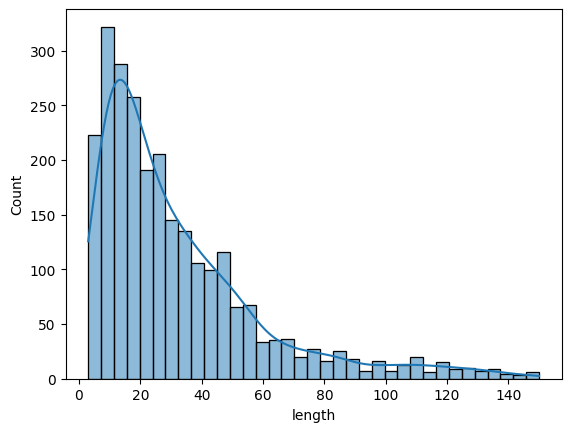

In [ ]:
import seaborn as sns

counter_list = []
for text_seq in train_input_ids:
    counter_list.append(tf.math.count_nonzero(text_seq).numpy())

counter_df = pd.DataFrame(counter_list, columns=['length'])
sns.histplot(data=counter_df, x='length', kde=True)

print(
    f"0이 아닌 인덱스의 길이가 최대치인 문장의 비율: "
    f"{(len(counter_df[counter_df['length'] == MAX_LENGTH]) / len(counter_df)) * 100:.3f}%"
)

# 딕셔너리로 변경
BERT에 입력하기 위해서는 데이터를 딕셔너리 형태로 변경해야 한다.

In [ ]:
#딕셔너리 형태로 변환해서 출력
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
      }, label

 #데이터를 BERT에 넣을 수 있는 형태로 변경
def data_encode(input_ids_list, attention_mask_list, token_type_ids_list, label_list):
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

batch 사이즈는 한 번의 시행마다 몇 개씩 랜덤으로 뽑아서 학습시킬 것인지를 말하는 것이다.

예를 들어 4000개의 데이터를 80개의 batch 사이즈로 나누면 literation이 50개가 나온다. 그러면 50번만큼 데이터를 돌리는 것이다.

그리고 이렇게 모든 데이터를 한 번 씩 다 돌렸으면 그것을 하나의 epoch라고 한다.

epoch가 10이면 4000개의 데이터를 처음부터 끝까지 10번 학습했다는 뜻이다.

그러면 왜 같은 데이터로 여러번 학습시키느냐? 바로 학습마다 각 batch의 가중치를 다르게 설정하기 때문이다.

그렇기 때문에 epoch를 학습할 때마다 정확도가 올라간다. 하지만, 너무 많은 epoch를 학습시키면 안타깝게도 과적합의 문제가 발생한다. 따라서 과적합되지 않으면서도 정확도가 높은 적당한 수치를 입력해야 한다.

그러면 왜 한 번에 다 넣어서 돌리지 않고 batch를 나눠서 각각 돌리는지 궁금할 수 있다. 그 이유는 빅데이터 등에서 수십억개의 데이터를 한 번에 넣을 경우 RAM이 터질 수 있기 때문에 적은 양씩 나눠서 넣는 것이다.

In [ ]:
BATCH_SIZE = 24 # 임시로 batch 사이즈 64로 설정해둠

# 이쪽은 train_test_split 이용해서 나눈 경우

#학습 데이터
train_data_encoded = data_encode(train_input_ids, train_attention_masks, train_token_type_ids,y_train).batch(BATCH_SIZE)

#평가 데이터
test_data_encoded = data_encode(test_input_ids, test_attention_masks, test_token_type_ids, y_test).batch(BATCH_SIZE)


# 이쪽은 train / test / val 직접 나눈 경우

# #학습 데이터
# train_data_encoded = data_encode(train_input_ids, train_attention_masks, train_token_type_ids, train_df["Label"]).batch(BATCH_SIZE)

# #평가 데이터
# test_data_encoded = data_encode(test_input_ids, test_attention_masks, test_token_type_ids, test_df["Label"]).batch(BATCH_SIZE)

# #검증 데이터
# val_data_encoded = data_encode(val_input_ids, val_attention_masks, val_token_type_ids, val_df["Label"]).batch(BATCH_SIZE)

# GPU 사용가능 체크
이제 거의 마지막으로. GPU 가 사용한지 체크를 해줍니다.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


# 학습 실행

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

Dropout_Probablitity = 0.5

model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",                        # 12-layer짜리 BERT model 사용, 소문자로 바꿔줌.
    num_labels = 3,                             # 우리의 데이터셋에는 LABEL이 3개가 필요하쥬?
    hidden_dropout_prob=Dropout_Probablitity    # DropOut 0.5 실행, 안 하고 싶으면 주석처리하면 됨.
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#위에 무슨 모델 돌렸느냐에 따라 드롭아웃 적용/비적용임

optimizer = tf.keras.optimizers.Adam(1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

NUM_EPOCHS = 20
history = model.fit(train_data_encoded, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=test_data_encoded)


Epoch 1/20
107/107 [==============================] - 89s 388ms/step - loss: 1.1178 - accuracy: 0.3563 - val_loss: 1.0767 - val_accuracy: 0.4424
Epoch 2/20
107/107 [==============================] - 29s 270ms/step - loss: 1.0931 - accuracy: 0.3813 - val_loss: 1.0541 - val_accuracy: 0.4891
Epoch 3/20
107/107 [==============================] - 29s 270ms/step - loss: 1.0717 - accuracy: 0.4109 - val_loss: 1.0363 - val_accuracy: 0.4782
Epoch 4/20
107/107 [==============================] - 29s 270ms/step - loss: 1.0416 - accuracy: 0.4651 - val_loss: 1.0117 - val_accuracy: 0.4751
Epoch 5/20
107/107 [==============================] - 29s 271ms/step - loss: 0.8672 - accuracy: 0.6125 - val_loss: 0.7694 - val_accuracy: 0.6791
Epoch 6/20
107/107 [==============================] - 29s 270ms/step - loss: 0.6683 - accuracy: 0.7154 - val_loss: 0.6744 - val_accuracy: 0.7352
Epoch 7/20
107/107 [==============================] - 29s 270ms/step - loss: 0.5324 - accuracy: 0.7875 - val_loss: 0.5068 - val_ac

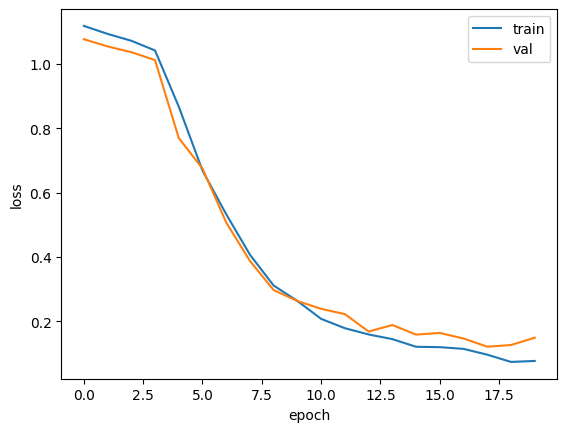

In [ ]:
#loss 확인

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

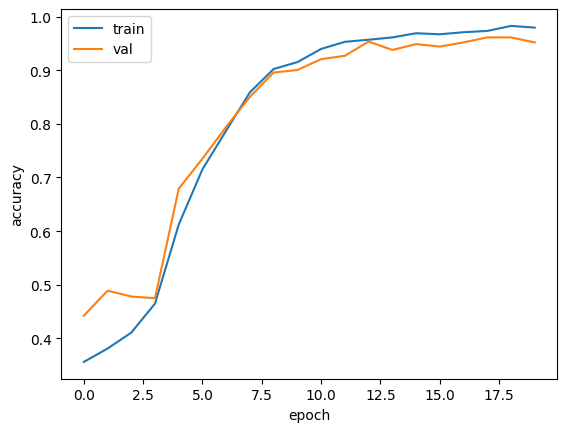

In [ ]:
#정확도 확인

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [ ]:
# unseendata에 대해서 잘 예측하는지 판단하기


num_labels = 3  # 클래스 개수

# TFBertForSequenceClassification 모델 초기화
#model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels = num_labels)

# Tokenizer 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# "unseendata" 준비
unseen_input_text = "its so bold, not light"
# 입력 데이터를 토큰화하고 모델에 주입하여 예측 결과 얻기
inputs = tokenizer(unseen_input_text, return_tensors="tf")
logits = model(inputs.input_ids, attention_mask=inputs.attention_mask)[0]
predictions = tf.nn.softmax(logits, axis=1)

# 예측 결과 출력
predicted_class = tf.argmax(predictions, axis=1).numpy()[0]
print("Predicted class:", predicted_class)
print("Class probabilities:", predictions.numpy()[0])
print("Class probabilities:", "unknown,       flavor1,        flavor2")

Predicted class: 1
Class probabilities: [0.32921746 0.4663759  0.20440662]
Class probabilities: unknown,       flavor1,        flavor2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import BertForMaskedLM, TFAutoModelWithLMHead

model.save_pretrained('bert_model_LB.h5')